In [2]:
import pandas as pd
import numpy as np
import pickle
import codecs
import time
from itertools import chain

from sklearn.utils import shuffle
from gensim.models import word2vec
from gensim.models import FastText
from gensim.test.utils import get_tmpfile

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from word_index import get_word_to_int #word

# 다음 뉴스 댓글 감정 분석 모델링 과정

1. 감정 데이터 불러오기
2. Word_index 구축
3. Embedding matrix 구축
4. CNN 학습

# 1. 감정 데이터 불러오기

In [4]:
download_PATH = "D:\\#0_WorkSpace\\뉴스 데이터\\"
update_PATH = "200713\\"
token_PATH = "200401_token_data\\"
embedding_PATH = "200401_embedding_data\\"

In [5]:
# 감정 데이터 불러오기
with open(download_PATH + update_PATH + "0710 comment_with_emo_over0.5.pkl", 'rb') as f:
    emotion_comment_df = pickle.load(f)
    
print("emotion_comment_df: ", emotion_comment_df.shape)
emotion_comment_df.sample(5)

emotion_comment_df:  (408607, 11)


,happy,sad,disgust,angry,surprised,fear,comment_id,comment,comment_token,check,emotion
1296230,0.0,0.0,0.0,1.0,0.0,0.0,11E02197682143D9B6BFAE9BE57A6B49,"적폐언론 조,중,동 쥐박이근혜가 방송장악으로 국민의 눈과 귀를 가리게만든 부역자 ...","[적폐, 언론, 조, 중, 쥐박, 이근혜, 방송, 장악, 국민, 눈, 귀, 가리다,...",[적폐],angry
1317931,1.0,0.0,0.0,0.0,0.0,0.0,615B041062CD488B9A64F66015744F7A,감사합니다~^^^ 너무 멋지십니다들!!!!!!!!!!,"[감사하다, 너무, 멋지다, 들다]",[감사하다],happy
1402812,1.0,0.0,0.0,0.0,0.0,0.0,2FCFB07B7C664BB5B1FDDAC1770C1E1E,세상에!!!! 열달 품고 배아파 낳은 자식이 의료사고로 죽었는데...... 2억으...,"[세상, 달, 품다, 배아, 파, 낳다, 자식, 의료사, 고로, 죽다, 배상, 되다...",[달],happy
776536,0.0,1.0,0.0,0.0,0.0,0.0,4929A7765C6A4430936CAE44BDC92168,뉴스룸 보고 사망소식 듣고 많이 놀랬네 ㅜㅜ 삼가고인의 명복을 빕니다,"[뉴스룸, 보고, 사망, 소식, 듣다, 많이, 놀래다, 삼가다, 명복, 비다]",[명복],sad
1003712,0.0,1.0,0.0,0.0,0.0,0.0,2BAA0975B2E34B3E92AD9DDDA084E3BA,빨리 바꾸세요. 국민 불안증 생기기전에,"[빨리, 바꾸다, 국민, 불안, 증, 생기, 기전]",[불안],sad


In [6]:
# Angry, Disgust, Happy, Sad, Fear, Surprised 6가지 감정 활용
emotion_comment_df.groupby("emotion").size()

emotion
angry        240971
disgust       17263
fear          14649
happy         44682
sad           83041
surprised      8001
dtype: int64

In [7]:
def get_shuffle_df(data, emotion, size):
    emotion_df = data[data["emotion"] == emotion]
    emotion_df = shuffle(emotion_df, random_state = 42).head(size)
    return emotion_df

# 각 감정별로 셔플한 다음 8,000개씩 부여 (Train = 85% / Test = 15%)
sample_count = 8000

hap = get_shuffle_df(emotion_comment_df, "happy", sample_count)
sad = get_shuffle_df(emotion_comment_df, "sad", sample_count)
dis = get_shuffle_df(emotion_comment_df, "disgust", sample_count)
ang = get_shuffle_df(emotion_comment_df, "angry", sample_count)
fea = get_shuffle_df(emotion_comment_df, "fear", sample_count)
sur = get_shuffle_df(emotion_comment_df, "surprised", sample_count)

# 데이터 합치기
total_emotion_df = pd.concat([hap, sad, dis, ang, fea, sur])
total_emotion_df = shuffle(total_emotion_df)

# 데이터 변환
comment_token_data = total_emotion_df['comment_token'].as_matrix() # as_matrix() = <class 'numpy.ndarray'>

# keras.utils to_categorical은 float형만 됨
# 6가지 감정 label

label_class = { 'happy': [1,0,0,0,0,0],
                'sad': [0,1,0,0,0,0],
                'disgust': [0,0,1,0,0,0],
                'angry': [0,0,0,1,0,0],
                'fear' : [0,0,0,0,1,0],
                'surprised' : [0,0,0,0,0,1]}

y_data = np.empty((len(total_emotion_df["emotion"]), 6))

# label_class[v], v must be string
for idx, emotion in enumerate(total_emotion_df["emotion"]):
    y_data[idx] = label_class[str(emotion)]
    
print("y_data shape", y_data.shape)
y_data[:5]

y_data shape (48000, 6)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


array([[0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.]])

# 2. Word_index 불러오기

In [10]:
"""
감정 데이터로 word_index 만든 다음,
학습에 사용할 데이터는 word_index 참고
"""

emotion_token_list = emotion_comment_df["comment_token"].tolist()
print("emotion_token_list: ", len(emotion_token_list))

# emotion data table로 big_to_int 만들고
emotion_tokenized_int, n_vocab, word_index = get_word_to_int(emotion_token_list, "total", None)

# 학습에 사용할 데이터로 train_tokenized_int 구성
train_tokenized_int, n_vocab, train_to_int = get_word_to_int(comment_token_data, "train", word_index)

emotion_token_list:  408607
놈(86380) 있다(78589) 되다(67410) 없다(58672) 아니다(48548) 보다(46792) 사람(39316) 쓰레기(39198) 같다(35233) 들다(33892) 않다(32565) 국민(31601) 적폐(28343) 그렇다(28149) 나라(26229) 
Total Vocab:  87786

있다(10322) 되다(8090) 없다(6973) 보다(6104) 아니다(6023) 사람(5596) 무섭다(5332) 않다(4667) 같다(4010) 더럽다(3962) 들다(3908) 그렇다(3415) 국민(3391) 더(3326) 가다(3280) 
Total Vocab:  87786



# 3.Embedding model 불러오기

In [11]:
# Word2vec model 불러오기
w2v_model = word2vec.Word2Vec.load(download_PATH + update_PATH + "0710 w2v_model")

# fasttext model 불러오기
fname = get_tmpfile(download_PATH + embedding_PATH + "fastText_0330.model")
fasttext_model = FastText.load(fname)

In [12]:
w2v_model.wv.most_similar(positive = "일본")

[('쪽바리', 0.6534008979797363),
 ('일본도', 0.6130391359329224),
 ('일본인', 0.5924339890480042),
 ('롯게', 0.592143177986145),
 ('김옥균', 0.5839071273803711),
 ('짓맓고', 0.5728364586830139),
 ('넘듬', 0.5719031095504761),
 ('갼다', 0.5700795650482178),
 ('가츠라', 0.5599955320358276),
 ('쪽발이', 0.5590065717697144)]

In [13]:
# Embedding matrix 만들기
emotion_word_list = list(chain(*emotion_token_list))
print("before: ", len(emotion_word_list))
emotion_word_list = list(set(emotion_word_list))
print("after: ", len(emotion_word_list))

empty_count = 0
emotion_w2v_embedding_list = []

for token_list in emotion_token_list:
    for token in token_list:
        try:
            word_weight = w2v_model[token] # word embedding model 사용
            emotion_w2v_embedding_list.append(word_weight)
        except: # word2vec model이 커버 못 하는 단어 수
            empty_count += 1
        
print("empty_count: ", empty_count)

embeddings_index = {}
embeddings_index = dict(zip(emotion_word_list, emotion_w2v_embedding_list))

# embedding_matrix 초기화
EMBEDDING_DIM = 300

# word_index = 단어에 index 부여
embedding_matrix = np.zeros((len(emotion_word_list) , EMBEDDING_DIM))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print("embedding_matrix: ", embedding_matrix.shape)
embedding_matrix

before:  7372271
after:  87786


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


empty_count:  0
embedding_matrix:  (87786, 300)


array([[-0.3020739 , -0.29084688, -0.15758172, ..., -0.2407058 ,
        -0.23538901, -0.32205519],
       [ 0.11805349, -0.02704787, -0.37710637, ..., -0.34065178,
        -0.1884623 , -0.28462461],
       [-0.07573161,  0.27437502, -0.30343065, ..., -0.1495382 ,
        -0.38591918, -0.33110824],
       ...,
       [-0.52066028,  0.3270452 , -0.32563189, ..., -0.2843684 ,
         0.21259801,  0.13129474],
       [ 0.12073746, -0.24189311, -0.15279078, ..., -0.01273903,
        -0.45075336,  0.19850667],
       [-0.28810543,  0.10296417, -0.04592679, ..., -0.86163765,
        -0.08438474, -0.41865173]])

In [14]:
import keras
from keras.layers import Dropout, Dense, Flatten
from keras.layers import LSTM, Conv1D, GlobalMaxPooling1D, MaxPooling1D
from keras.layers.embeddings import Embedding

from keras.datasets import reuters
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from keras.models import Sequential

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

C:\Users\USER\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [15]:
def pad_sequence(data, y, length):

    # 문장 길이 맞추기
    X_int = sequence.pad_sequences((data), maxlen=length)

    # 훈련셋과 시험셋으로 나눔
    X_train, X_test, y_train, y_test = train_test_split(X_int, y, test_size = 0.15, random_state = 42)
    print("X_train: %d, X_test: %d, y_train: %d, y_test: %d" % (X_train.shape[0], X_test.shape[0], 
                                                                y_train.shape[0], y_test.shape[0]))
    print ("")
    print (X_train.shape)
    print (X_train)
    
    print ("")
    print (y_train.shape)
    print (y_train)
    
    return X_train, X_test, y_train, y_test

In [16]:
X_train, X_test, y_train, y_test = pad_sequence(train_tokenized_int, y_data, 20) # comment_tokenized_int2 ??? -> 변수 수정

X_train: 40800, X_test: 7200, y_train: 40800, y_test: 7200

(40800, 20)
[[    0     0     0 ... 63640 63640 67800]
 [    0     0     0 ... 29067 81141 73149]
 [71870 32876 13198 ... 15340 26630 22992]
 ...
 [    0     0     0 ... 63829 46414 28470]
 [    0     0     0 ... 28746 29199 45414]
 [    0     0     0 ... 56231 16013 38359]]

(40800, 6)
[[0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]


# 4. CNN 학습

In [25]:
from keras.layers import GlobalAveragePooling1D
from keras.layers import Conv2D
from keras.layers import Embedding

from keras import optimizers

import keras.backend.tensorflow_backend as K

from tensorflow.python.client import device_lib

import matplotlib
import matplotlib.pyplot as plt

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 372520161604669945
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9129664184
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 2794375487912063196
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:17:00.0, compute capability: 6.1"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 9129664184
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 6099936660543771351
physical_device_desc: "device: 1, name: GeForce GTX 1080 Ti, pci bus id: 0000:65:00.0, compute capability: 6.1"
]


In [29]:
"""
GPU 없을 경우,
with K.tf.device('/gpu:0'):
코드를 제거 할 것.
"""

def cnn_model(dropout):
    # gpu 설정
    with K.tf.device('/gpu:0'):
        model_Conv = Sequential()        

        EMBEDDING_DIM = 300
        MAX_SEQUENCE_LENGTH = 20

        model_Conv.add(Embedding(len(word_index),
                        EMBEDDING_DIM,
                        weights = [embedding_matrix],
                        input_length = MAX_SEQUENCE_LENGTH,
                        trainable = False) )

        model_Conv.add(Conv1D(256,
                            3,
                            padding='same',
                            activation='relu',
                            strides= 1))
        model_Conv.add(Dropout(dropout))

        model_Conv.add(GlobalMaxPooling1D())
        
        model_Conv.add(Dense(128, activation='relu'))
        model_Conv.add(Dropout(dropout))

        model_Conv.add(Dense(32, activation='relu'))
        model_Conv.add(Dropout(dropout))

        model_Conv.add(Dense(6, activation='softmax'))
 
        model_Conv.compile(
            loss = 'categorical_crossentropy',
            optimizer = 'adam',
            metrics = ['accuracy']) 

        # Model 학습, tensorflow chart 활용
        # tb_hist = keras.callbacks.TensorBoard(log_dir = './graph', histogram_freq = 0, 
        #                                           write_graph = True, write_images = True)
        
        model_Conv.summary()
        
        conv_model = model_Conv.fit(
            X_train, y_train,
            epochs = 200, batch_size = 64,
            validation_split = 0.1,#0.1로 고정할 것
            callbacks = [EarlyStopping(monitor = 'val_loss', patience = 10)], # tb_hist
            verbose = 1,
            shuffle=True)

        # final evaluation of the model
        print ("")
        scores = model_Conv.evaluate(X_test, y_test, verbose=1)
        print ("")
        print ("loss: %.2f%%" % (scores[0] * 100))
        print ("Accuracy: %.2f%%" % (scores[1] * 100))

        # 과정 살펴보기
        matplotlib.rcParams.update({'font.size': 12})
        fig, loss_ax = plt.subplots()
        #krkwplt.style.use("ggplot")
        acc_ax = loss_ax.twinx()

        loss_ax.plot(conv_model.history['loss'], 'y', label= 'train loss')
        loss_ax.plot(conv_model.history['val_loss'], 'r', label= 'val loss')

        acc_ax.plot(conv_model.history['accuracy'], 'b', label = 'train acc')
        acc_ax.plot(conv_model.history['val_accuracy'], 'g', label = 'val acc')

        loss_ax.set_xlabel('epoch')
        loss_ax.set_ylabel('loss')
        acc_ax.set_ylabel('accuracy')

        loss_ax.legend(loc='right')
        acc_ax.legend(loc='best')
        fig = plt.gcf()
        plt.title("CNN Model")
        plt.show()
        
        return model_Conv

In [30]:
def cnn_model2(dropout):   
    # gpu 설정
    with K.tf.device('/gpu:0'):
        model_Conv2 = Sequential()        

        EMBEDDING_DIM = 300
        MAX_SEQUENCE_LENGTH = 20
        
        # 3 Conv1D layers
        model_Conv2.add(Embedding(len(word_index),
                        EMBEDDING_DIM,
                        weights = [embedding_matrix],
                        input_length = MAX_SEQUENCE_LENGTH,
                        trainable = False) )
        
        model_Conv2.add(Conv1D(256,
                            1,
                            padding='same',
                            activation='relu',
                            strides= 1))
        model_Conv2.add(Dropout(dropout))
        
        model_Conv2.add(Conv1D(256,
                            1,
                            padding='same',
                            activation='relu',
                            strides= 1))
        model_Conv2.add(Dropout(dropout))
        
        model_Conv2.add(Conv1D(256,
                            1,
                            padding='same',
                            activation='relu',
                            strides= 1))
        model_Conv2.add(Dropout(dropout))

        model_Conv2.add(GlobalMaxPooling1D())
        
        model_Conv2.add(Dense(256, activation='relu'))
        model_Conv2.add(Dropout(dropout))
        
        model_Conv2.add(Dense(64, activation='relu'))
        model_Conv2.add(Dropout(dropout))

        model_Conv2.add(Dense(6, activation='softmax'))
        
        # optimizer 사용
        Adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)
        
        model_Conv2.compile(
            loss = 'categorical_crossentropy',
            optimizer = Adam,
            metrics = ['accuracy'])
        
        model_Conv2.summary()
        # Model 학습, tensorflow chart 활용
        # tb_hist = keras.callbacks.TensorBoard(log_dir = './graph', histogram_freq = 0, 
        #                                           write_graph = True, write_images = True)
        conv_model2 = model_Conv2.fit(
            X_train, y_train,
            epochs = 200, batch_size = 64,
            validation_split = 0.1,#0.1로 고정할 것
            callbacks = [EarlyStopping(monitor = 'val_loss', patience = 10)], # tb_hist
            verbose = 1,
            shuffle=True)

        # final evaluation of the model
        print ("")
        scores = model_Conv2.evaluate(X_test, y_test, verbose=1)
        print ("")
        print ("loss: %.2f%%" % (scores[0] * 100))
        print ("Accuracy: %.2f%%" % (scores[1] * 100))

        # 과정 살펴보기
        matplotlib.rcParams.update({'font.size': 12})
        fig, loss_ax = plt.subplots()
        #krkwplt.style.use("ggplot")
        acc_ax = loss_ax.twinx()

        loss_ax.plot(conv_model2.history['loss'], 'y', label= 'train loss')
        loss_ax.plot(conv_model2.history['val_loss'], 'r', label= 'val loss')

        acc_ax.plot(conv_model2.history['accuracy'], 'b', label = 'train acc')
        acc_ax.plot(conv_model2.history['val_accuracy'], 'g', label = 'val acc')

        loss_ax.set_xlabel('epoch')
        loss_ax.set_ylabel('loss')
        acc_ax.set_ylabel('accuracy')

        loss_ax.legend(loc='right')
        acc_ax.legend(loc='best')
        fig = plt.gcf()
        plt.title("CNN Model")
        plt.show()
        
        return model_Conv2

In [32]:
def cnn_model3(dropout):
    # gpu 설정
    with K.tf.device('/gpu:0'):
        model_Conv3 = Sequential()        

        EMBEDDING_DIM = 300
        MAX_SEQUENCE_LENGTH = 20

        model_Conv3.add(Embedding(len(word_index),
                        EMBEDDING_DIM,
                        weights = [embedding_matrix],
                        input_length = MAX_SEQUENCE_LENGTH,
                        trainable = False) )
        # 6 Conv1D layers
        model_Conv3.add(Conv1D(512,
                            1,
                            padding='same',
                            activation='relu',
                            strides= 1))
        model_Conv3.add(Dropout(dropout))
        
        model_Conv3.add(Conv1D(512,
                            1,
                            padding='same',
                            activation='relu',
                            strides= 1))
        model_Conv3.add(Dropout(dropout))
        
        model_Conv3.add(Conv1D(512,
                            1,
                            padding='same',
                            activation='relu',
                            strides= 1))
        model_Conv3.add(Dropout(dropout))
        
        model_Conv3.add(Conv1D(256,
                            1,
                            padding='same',
                            activation='relu',
                            strides= 1))
        model_Conv3.add(Dropout(dropout))
        
        model_Conv3.add(Conv1D(256,
                            1,
                            padding='same',
                            activation='relu',
                            strides= 1))
        model_Conv3.add(Dropout(dropout))
        
        model_Conv3.add(Conv1D(256,
                            1,
                            padding='same',
                            activation='relu',
                            strides= 1))
        model_Conv3.add(Dropout(dropout))

        model_Conv3.add(GlobalMaxPooling1D())
        
        model_Conv3.add(Dense(256, activation='relu'))
        model_Conv3.add(Dropout(dropout))
        
        model_Conv3.add(Dense(64, activation='relu'))
        model_Conv3.add(Dropout(dropout))

        model_Conv3.add(Dense(6, activation='softmax'))
        
        # optimizer 사용
        Adam = optimizers.Adam(lr=0.0008, beta_1=0.9, beta_2=0.999)
        
        model_Conv3.compile(
            loss = 'categorical_crossentropy',
            optimizer = Adam,
            metrics = ['accuracy']) 
        
        # model_Conv2.summary()
        # Model 학습, tensorflow chart 활용
        # tb_hist = keras.callbacks.TensorBoard(log_dir = './graph', histogram_freq = 0, 
        #                                           write_graph = True, write_images = True)
        conv_model3 = model_Conv3.fit(
            X_train, y_train,
            epochs = 200, batch_size = 64,
            validation_split = 0.1,#0.1로 고정할 것
            callbacks = [EarlyStopping(monitor = 'val_loss', patience = 20)], # tb_hist
            verbose = 1,
            shuffle=True)

        # final evaluation of the model
        print ("")
        scores = model_Conv3.evaluate(X_test, y_test, verbose=1)
        print ("")
        print ("loss: %.2f%%" % (scores[0] * 100))
        print ("Accuracy: %.2f%%" % (scores[1] * 100))

        # 과정 살펴보기
        matplotlib.rcParams.update({'font.size': 12})
        fig, loss_ax = plt.subplots()
        #krkwplt.style.use("ggplot")
        acc_ax = loss_ax.twinx()

        loss_ax.plot(conv_model3.history['loss'], 'y', label= 'train loss')
        loss_ax.plot(conv_model3.history['val_loss'], 'r', label= 'val loss')

        acc_ax.plot(conv_model3.history['accuracy'], 'b', label = 'train acc')
        acc_ax.plot(conv_model3.history['val_accuracy'], 'g', label = 'val acc')

        loss_ax.set_xlabel('epoch')
        loss_ax.set_ylabel('loss')
        acc_ax.set_ylabel('accuracy')

        loss_ax.legend(loc='right')
        acc_ax.legend(loc='best')
        fig = plt.gcf()
        plt.title("CNN Model")
        plt.show()
        
        return model_Conv3

# Test

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 300)           26335800  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 256)           230656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 256)           0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)               

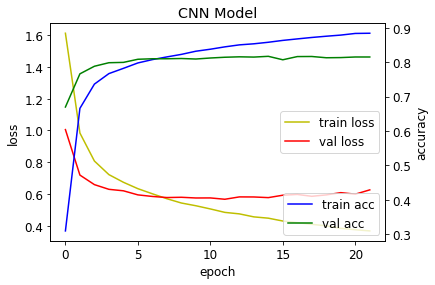

In [21]:
cnn = cnn_model(0.5)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 300)           26335800  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 20, 256)           77056     
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 256)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 20, 256)           65792     
_________________________________________________________________
dropout_5 (Dropout)          (None, 20, 256)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 20, 256)           65792     
_________________________________________________________________
dropout_6 (Dropout)          (None, 20, 256)          

Epoch 42/200
36720/36720 [==============================] - 3s 81us/step - loss: 0.6188 - accuracy: 0.7980 - val_loss: 0.5760 - val_accuracy: 0.8010
Epoch 43/200
36720/36720 [==============================] - 3s 93us/step - loss: 0.6171 - accuracy: 0.7983 - val_loss: 0.5776 - val_accuracy: 0.8007
Epoch 44/200
36720/36720 [==============================] - 3s 89us/step - loss: 0.6142 - accuracy: 0.8004 - val_loss: 0.5773 - val_accuracy: 0.7993
Epoch 45/200
36720/36720 [==============================] - 3s 93us/step - loss: 0.6135 - accuracy: 0.8004 - val_loss: 0.5787 - val_accuracy: 0.8032
Epoch 46/200
36720/36720 [==============================] - 3s 85us/step - loss: 0.6094 - accuracy: 0.7999 - val_loss: 0.5703 - val_accuracy: 0.8044
Epoch 47/200
36720/36720 [==============================] - 3s 81us/step - loss: 0.6075 - accuracy: 0.8007 - val_loss: 0.5715 - val_accuracy: 0.8025
Epoch 48/200
36720/36720 [==============================] - 3s 78us/step - loss: 0.6027 - accuracy: 0.8031

Epoch 97/200
36720/36720 [==============================] - 3s 90us/step - loss: 0.5388 - accuracy: 0.8191 - val_loss: 0.5367 - val_accuracy: 0.8147
Epoch 98/200
36720/36720 [==============================] - 3s 89us/step - loss: 0.5430 - accuracy: 0.8201 - val_loss: 0.5377 - val_accuracy: 0.8174
Epoch 99/200
36720/36720 [==============================] - 3s 93us/step - loss: 0.5348 - accuracy: 0.8207 - val_loss: 0.5333 - val_accuracy: 0.8174
Epoch 100/200
36720/36720 [==============================] - 3s 89us/step - loss: 0.5373 - accuracy: 0.8218 - val_loss: 0.5351 - val_accuracy: 0.8157
Epoch 101/200
36720/36720 [==============================] - 3s 90us/step - loss: 0.5376 - accuracy: 0.8208 - val_loss: 0.5334 - val_accuracy: 0.8169
Epoch 102/200
36720/36720 [==============================] - 3s 90us/step - loss: 0.5358 - accuracy: 0.8204 - val_loss: 0.5314 - val_accuracy: 0.8159
Epoch 103/200
36720/36720 [==============================] - 3s 92us/step - loss: 0.5339 - accuracy: 0.

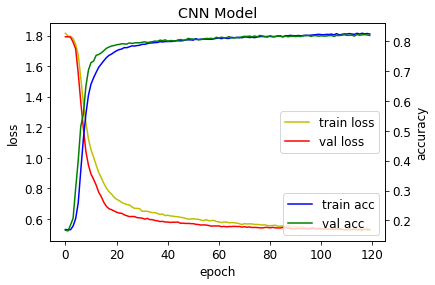

In [22]:
cnn2 = cnn_model2(0.5) # 82.69

Train on 36720 samples, validate on 4080 samples
Epoch 1/200
36720/36720 [==============================] - 6s 159us/step - loss: 1.8013 - accuracy: 0.1658 - val_loss: 1.7920 - val_accuracy: 0.1635
Epoch 2/200
36720/36720 [==============================] - 5s 143us/step - loss: 1.7928 - accuracy: 0.1650 - val_loss: 1.7920 - val_accuracy: 0.1635
Epoch 3/200
36720/36720 [==============================] - 5s 142us/step - loss: 1.7924 - accuracy: 0.1670 - val_loss: 1.7919 - val_accuracy: 0.1694
Epoch 4/200
36720/36720 [==============================] - 5s 143us/step - loss: 1.7920 - accuracy: 0.1693 - val_loss: 1.7919 - val_accuracy: 0.1694
Epoch 5/200
36720/36720 [==============================] - 5s 145us/step - loss: 1.7749 - accuracy: 0.1815 - val_loss: 1.6456 - val_accuracy: 0.2520
Epoch 6/200
36720/36720 [==============================] - 5s 134us/step - loss: 1.6461 - accuracy: 0.2626 - val_loss: 1.5567 - val_accuracy: 0.3025
Epoch 7/200
36720/36720 [==============================] 

36720/36720 [==============================] - 5s 140us/step - loss: 1.0233 - accuracy: 0.5965 - val_loss: 1.0970 - val_accuracy: 0.5846
Epoch 56/200
36720/36720 [==============================] - 5s 134us/step - loss: 1.0080 - accuracy: 0.6047 - val_loss: 1.0763 - val_accuracy: 0.5745
Epoch 57/200
36720/36720 [==============================] - 5s 133us/step - loss: 0.9958 - accuracy: 0.6080 - val_loss: 1.0753 - val_accuracy: 0.5794
Epoch 58/200
36720/36720 [==============================] - 5s 130us/step - loss: 0.9908 - accuracy: 0.6125 - val_loss: 1.0684 - val_accuracy: 0.5755
Epoch 59/200
36720/36720 [==============================] - 5s 129us/step - loss: 0.9878 - accuracy: 0.6124 - val_loss: 1.0466 - val_accuracy: 0.5858
Epoch 60/200
36720/36720 [==============================] - 5s 128us/step - loss: 0.9741 - accuracy: 0.6188 - val_loss: 1.0887 - val_accuracy: 0.5779
Epoch 61/200
36720/36720 [==============================] - 5s 127us/step - loss: 0.9746 - accuracy: 0.6199 - val

36720/36720 [==============================] - 5s 125us/step - loss: 0.6653 - accuracy: 0.7865 - val_loss: 0.6808 - val_accuracy: 0.7833
Epoch 110/200
36720/36720 [==============================] - 5s 126us/step - loss: 0.6646 - accuracy: 0.7856 - val_loss: 0.6734 - val_accuracy: 0.7870
Epoch 111/200
36720/36720 [==============================] - 5s 125us/step - loss: 0.6651 - accuracy: 0.7839 - val_loss: 0.6871 - val_accuracy: 0.7887
Epoch 112/200
36720/36720 [==============================] - 5s 140us/step - loss: 0.6707 - accuracy: 0.7834 - val_loss: 0.7001 - val_accuracy: 0.7895
Epoch 113/200
36720/36720 [==============================] - 5s 141us/step - loss: 0.6655 - accuracy: 0.7855 - val_loss: 0.6825 - val_accuracy: 0.7907
Epoch 114/200
36720/36720 [==============================] - 5s 143us/step - loss: 0.6612 - accuracy: 0.7845 - val_loss: 0.6582 - val_accuracy: 0.7917
Epoch 115/200
36720/36720 [==============================] - 5s 142us/step - loss: 0.6690 - accuracy: 0.7821

36720/36720 [==============================] - 5s 125us/step - loss: 0.6415 - accuracy: 0.7901 - val_loss: 0.6526 - val_accuracy: 0.7907
Epoch 164/200
36720/36720 [==============================] - 5s 127us/step - loss: 0.6337 - accuracy: 0.7924 - val_loss: 0.6426 - val_accuracy: 0.7929
Epoch 165/200
36720/36720 [==============================] - 5s 124us/step - loss: 0.6282 - accuracy: 0.7939 - val_loss: 0.6472 - val_accuracy: 0.7946
Epoch 166/200
36720/36720 [==============================] - 5s 123us/step - loss: 0.6327 - accuracy: 0.7941 - val_loss: 0.6643 - val_accuracy: 0.7907
Epoch 167/200
36720/36720 [==============================] - 5s 123us/step - loss: 0.6270 - accuracy: 0.7939 - val_loss: 0.6703 - val_accuracy: 0.7831
Epoch 168/200
36720/36720 [==============================] - 5s 124us/step - loss: 0.6258 - accuracy: 0.7946 - val_loss: 0.6660 - val_accuracy: 0.7900
Epoch 169/200
36720/36720 [==============================] - 5s 124us/step - loss: 0.6267 - accuracy: 0.7956

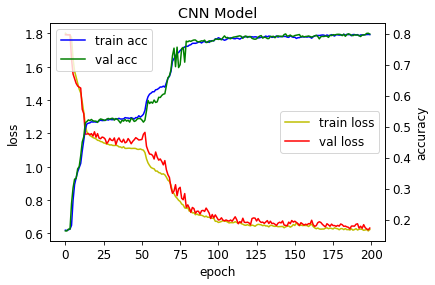

In [33]:
cnn3 = cnn_model3(0.5)

In [43]:
predict = cnn2.predict(X_test, batch_size = 32)
classes = cnn2.predict_classes(X_test, batch_size = 32)

print("predict")
print(predict)
print()
print("classes")
print(classes)

predict
[[1.8003535e-01 2.2428341e-01 3.8413797e-02 4.0672537e-02 6.8513341e-02
  4.4808158e-01]
 [3.0060872e-01 3.4275061e-01 5.4508368e-03 6.3430578e-03 1.9975894e-03
  3.4284917e-01]
 [5.5504031e-02 9.5630750e-02 6.5575296e-01 5.9368778e-02 4.2852294e-02
  9.0891212e-02]
 ...
 [1.4100774e-03 7.7316999e-03 2.9561552e-03 1.9443914e-01 7.8877139e-01
  4.6915393e-03]
 [2.4395301e-03 2.0774375e-03 2.4008511e-03 9.8296325e-04 9.9152970e-01
  5.6946138e-04]
 [6.7989416e-03 2.8991636e-02 9.2538208e-01 1.8995756e-02 6.8872641e-03
  1.2944343e-02]]

classes
[5 5 2 ... 4 4 2]


In [42]:
happy = 0
sad = 0
disgust = 0
surprised = 0
fear = 0
angry = 0

for item in classes:
    if (item == 0):
        happy += 1
    elif (item == 1):
        sad += 1
    elif (item == 2):
        disgust += 1
    elif (item == 3):
        surprised += 1
    elif (item == 4):
        fear += 1
    else:
        angry += 1

print("happy     ", happy)
print("sad       ", sad)
print("disgust   ", disgust)
print("surprised ", surprised)
print("fear      ", fear)
print("angry     ", angry)

happy      1110
sad        1123
disgust    1250
surprised  1230
fear       1280
angry      1207
